In [31]:
import os
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math


from scipy.stats import norm
from sklearn.decomposition import PCA # Основной класс, который нам нужен
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler # Стандартизация, обязательно воспользуйтесь именно этим классом
from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [5]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
warnings.filterwarnings("ignore")
np.random.seed(42)

### Loading data:

In [3]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/scRNAseq_CITEseq.txt -O scRNAseq_CITEseq.txt

--2021-12-11 11:25:20--  https://kodomo.fbb.msu.ru/FBB/year_20/scRNAseq_CITEseq.txt
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17128751 (16M) [text/plain]
Saving to: ‘scRNAseq_CITEseq.txt’

scRNAseq_CITEseq.tx 100%[===================>]  16,33M  2,16MB/s    in 8,6s    

2021-12-11 11:25:29 (1,91 MB/s) - ‘scRNAseq_CITEseq.txt’ saved [17128751/17128751]



In [6]:
scRNAseq = pd.read_csv("scRNAseq_CITEseq.txt", sep="\t")
X_scRNAseq = scRNAseq.iloc[:, 0:(scRNAseq.shape[1] - 1)]
Y_scRNAseq = scRNAseq.iloc[:, scRNAseq.shape[1] - 1]
X_scRNAseq = np.log(X_scRNAseq + 1)
scRNAseq.shape

(8617, 977)

In [7]:
pca = PCA(n_components=X_scRNAseq.shape[1]).fit(X_scRNAseq)
X_reduced = pca.transform(X_scRNAseq) 

### How many PCs should be get?

#### 1. Possibility

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


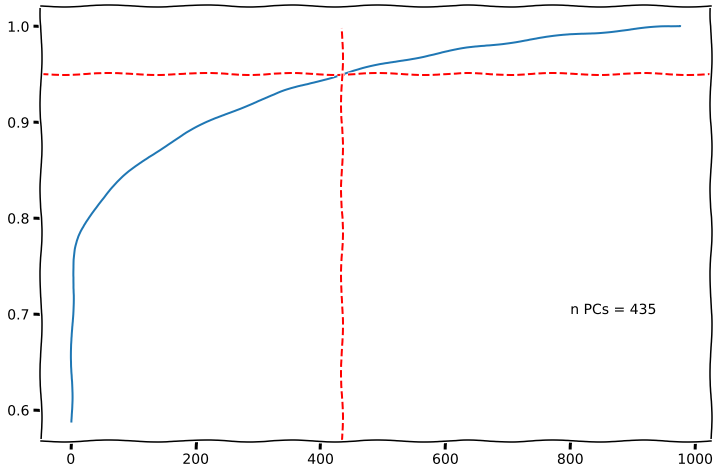

In [6]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
plt.text(800, 0.7, f"{chosen_number} PCs explaining 95 % variance", clip_on=True);

#### 2. Possibility

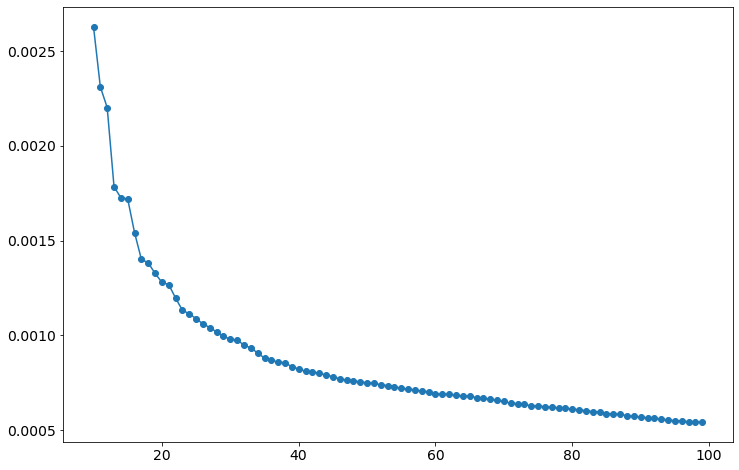

In [7]:
# Он здесь очень плохо подходит, так как слишком много признаков
plt.scatter(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.plot(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

#### 3. Possibility

In [8]:
def shuffle_dataset(dataset):
    """
    Мешаем данные
    """
    random_data =  {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для перемешанных данных
    """
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")

        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
        
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    """
    Считаем, сколько дисперсии объясняет каждая PC для реальных данных
    """
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    
    return pca.explained_variance_ratio_


# Дальше идет ряд графиков для визуализации

def plot_mean_and_ci(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_ci(ax, variance_by_chance, label="chance", color_mean="red", color_shading="red")


def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name, step=1):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ratio", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, step), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

    
def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))
    
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, step), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=p_values.shape[0], color="red", linestyles="dashed", lw=3)


def calc_permutat_pval(real_values, permut_values, eps=None):
    """
    Сравниваем долю объясненной дисперсии для реальных данных и для перемешанных
    """
    eps = eps or (1 / (permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

    
def pca_analysis(ax1, ax2, dataset, title, n_components = None, n_replics = 1000, step=1):
    """
    Главная функция, которая просто запускает все, что выше
    """
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


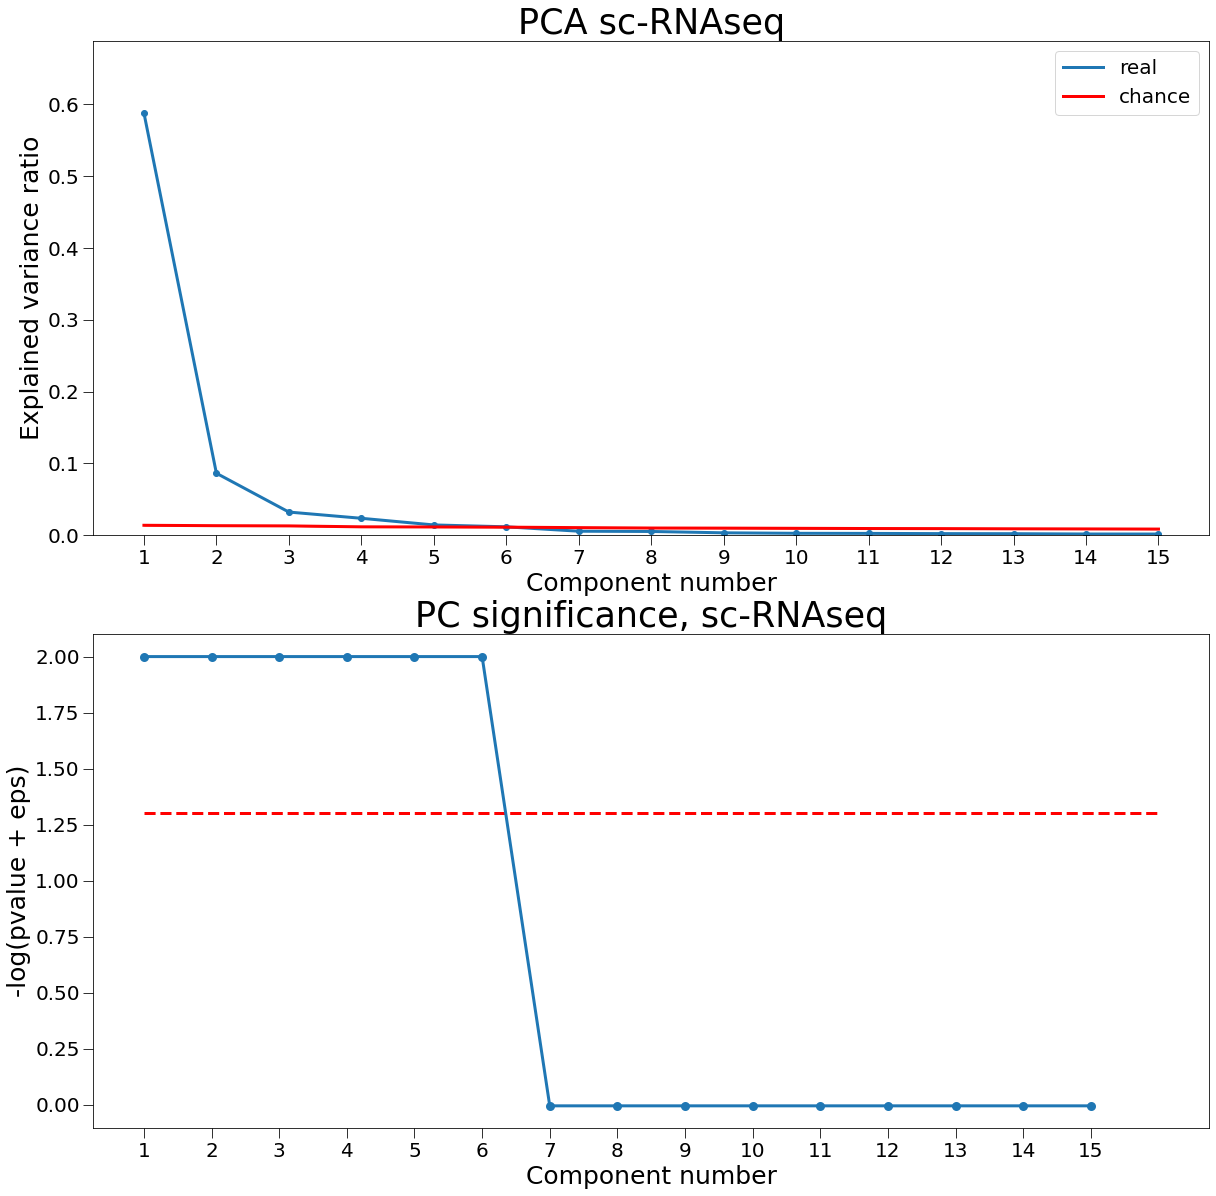

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, X_scRNAseq, "sc-RNAseq", n_replics=10, n_components=15)

We could take 6 PCs which account for 76 % of variance. But we forgot to **STANDARDIZE**.

In [9]:
X_scaled = StandardScaler().fit_transform(scRNAseq)

In [10]:
pca = PCA(n_components=X_scRNAseq.shape[1])
pca.fit(X_scaled)

PCA(n_components=976)

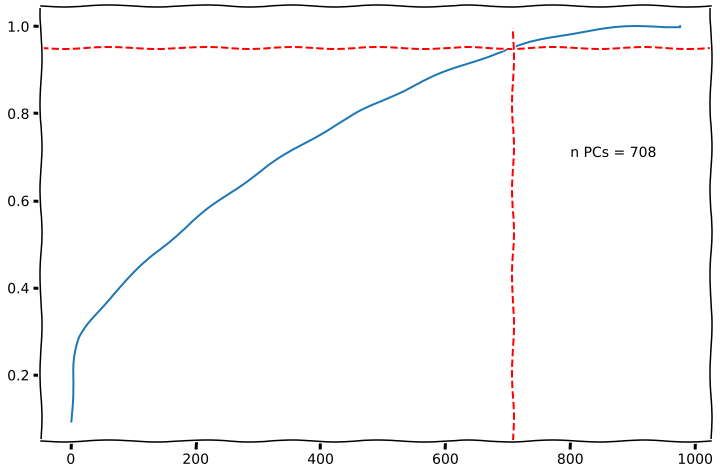

In [12]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

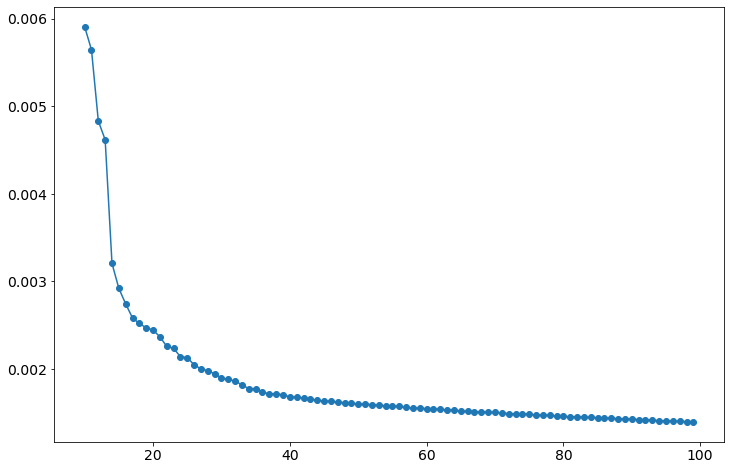

In [13]:
plt.scatter(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.plot(np.arange(10, 100), pca.explained_variance_ratio_[10:100])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

0 iter


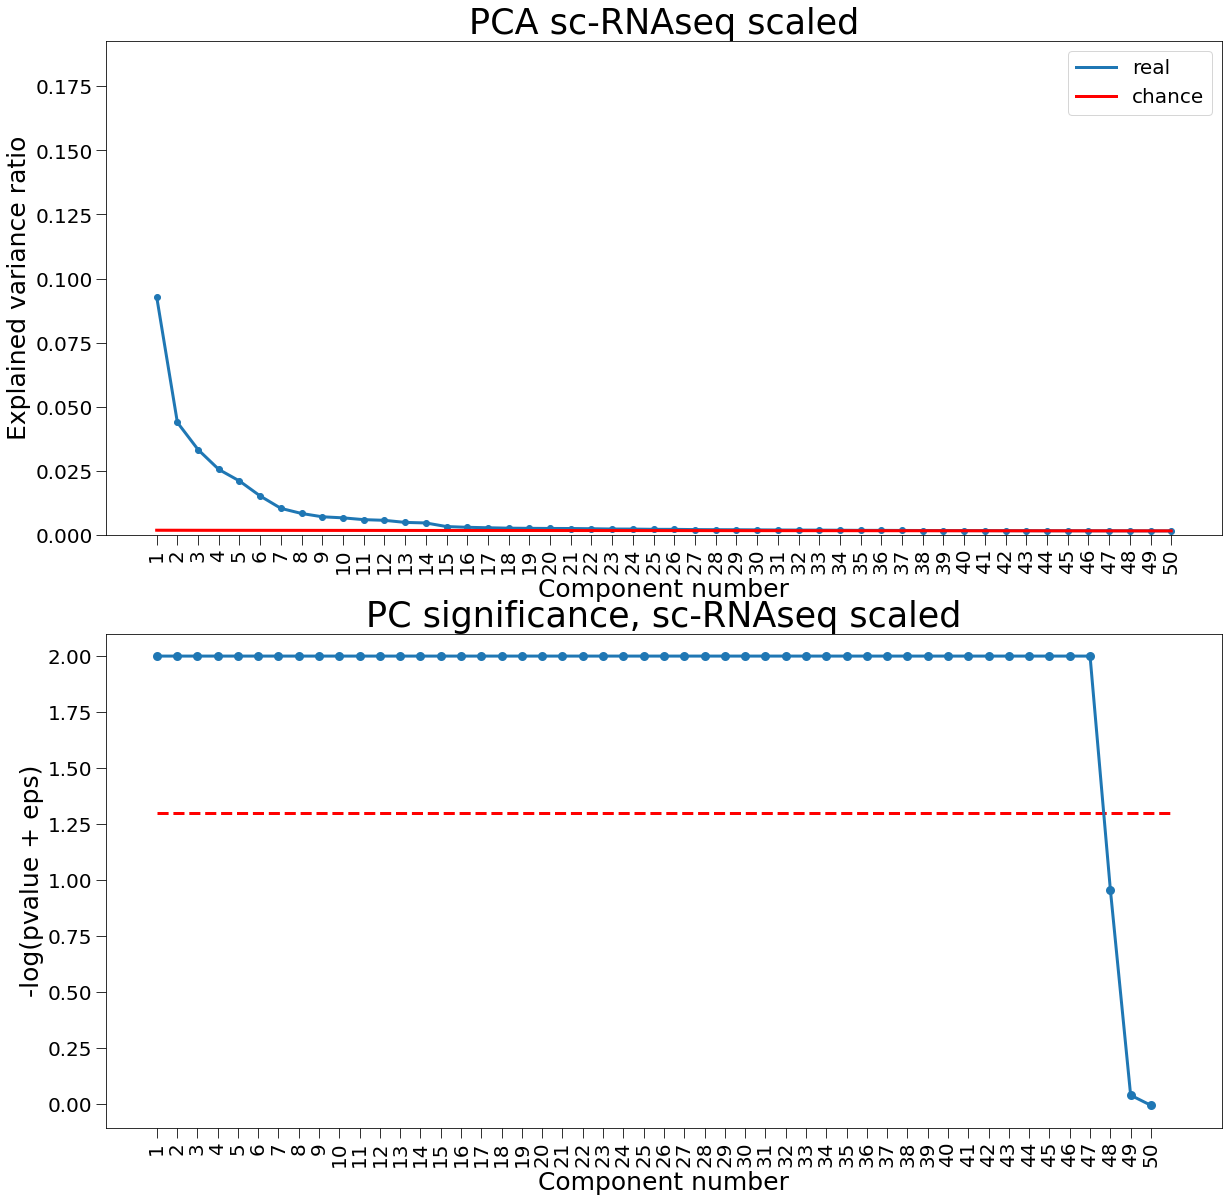

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, pd.DataFrame(X_scaled), "sc-RNAseq scaled", n_replics=10, n_components=50)
ax1.set_xticklabels(np.arange(1, 51), rotation=90)
ax2.set_xticklabels(np.arange(1, 51), rotation=90);

## t-SNE

In [124]:
def tsne(X_scaled, Y_scRNAseq, n_components, perplexities, random_state, n_iter):
    n_clusters = len(np.unique(Y_scRNAseq))
    ls_X_embedded = []
    n_cols = 2
    n_rows = math.ceil(len(np.unique(perplexities))/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, squeeze = False)
    fig.suptitle("t-SNE for scRNA with different perplexities")
    plt.setp(ax[-1, :], xlabel='t-SNE 1')
    plt.setp(ax[:, 0], ylabel='t-SNE 2')
    n_row = 0
    for i, perplexity in enumerate(perplexities):
        tsne = TSNE(n_components = n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
        X_embedded = tsne.fit_transform(X_scaled)
        if i % 2 == 0:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, legend=0, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
        elif i % 2 == 1 and n_row == n_rows-1:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
            cur_ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
        else:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, legend=0, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
            n_row += 1
        
    fig.tight_layout()
    plt.show()

In [125]:
n_compnents = 2
perplexities = np.arange(10, 110, 10)

13


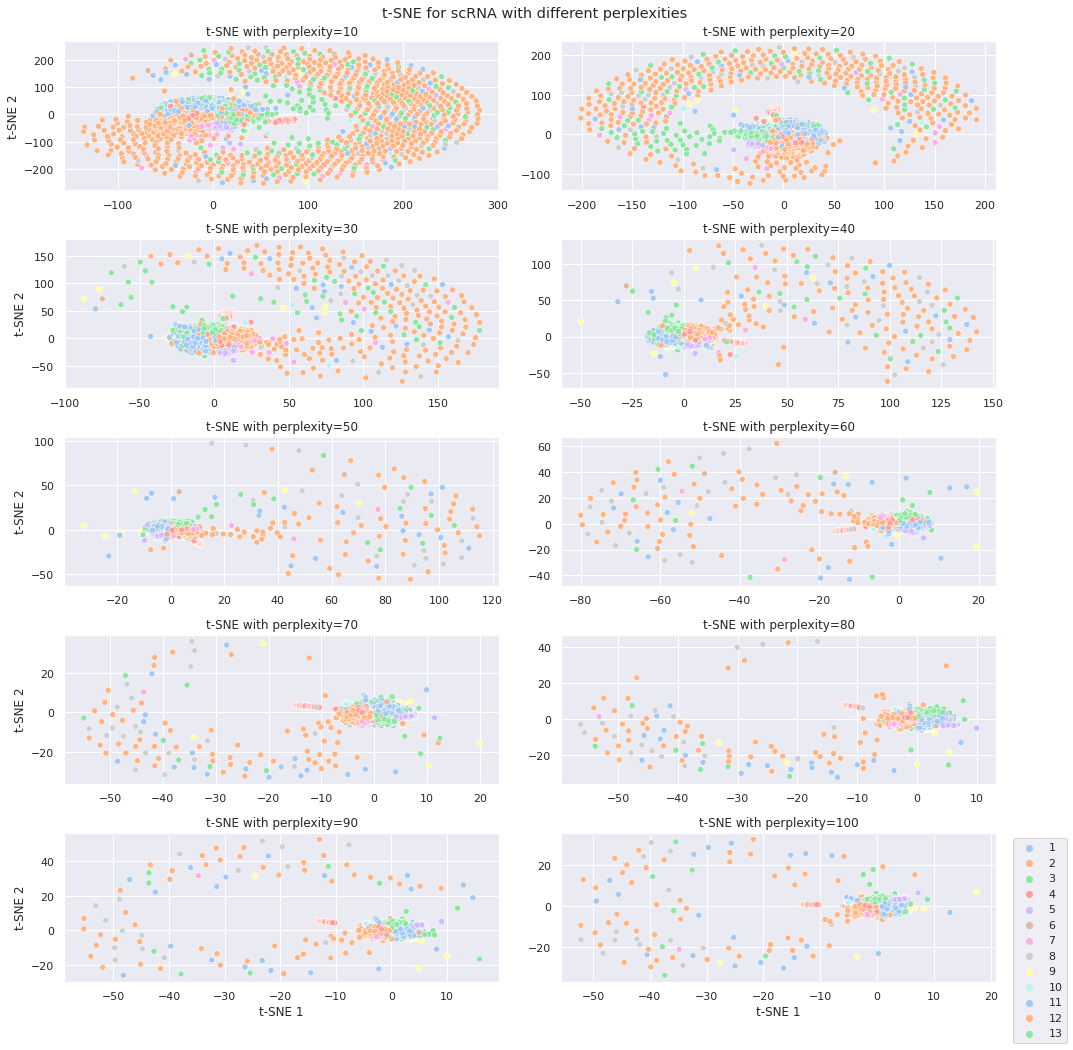

In [127]:
tsne(X_scaled, Y_scRNAseq, n_components=2, perplexities=perplexities, random_state=42, n_iter=5000)

Mmm, that didn't work.

In [133]:
def tsne(X_scaled, Y_scRNAseq, n_components, perplexities, random_state, n_iter, metric, init):
    n_clusters = len(np.unique(Y_scRNAseq))
    ls_X_embedded = []
    n_cols = 2
    n_rows = math.ceil(len(perplexities)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, squeeze = False)
    fig.suptitle("t-SNE for scRNA with different perplexities")
    plt.setp(ax[-1, :], xlabel='t-SNE 1')
    plt.setp(ax[:, 0], ylabel='t-SNE 2')
    n_row = 0
    for i, perplexity in enumerate(perplexities):
        tsne = TSNE(n_components = n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state, metric=metric, init=init)
        X_embedded = tsne.fit_transform(X_scaled)
        if i % 2 == 0:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, legend=0, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
        elif i % 2 == 1 and n_row == n_rows-1:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
            cur_ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
        else:
            cur_ax = ax[n_row, i%2]
            sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=Y_scRNAseq, legend=0, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
            cur_ax.set_title(f"t-SNE with perplexity={perplexity}")
            n_row += 1
        
    fig.tight_layout()
    plt.show()

Taking all the variables, but giving first two components from PCA as embedding, `init = PCA(n_components=2).fit_transform(X_scaled)
`:

13


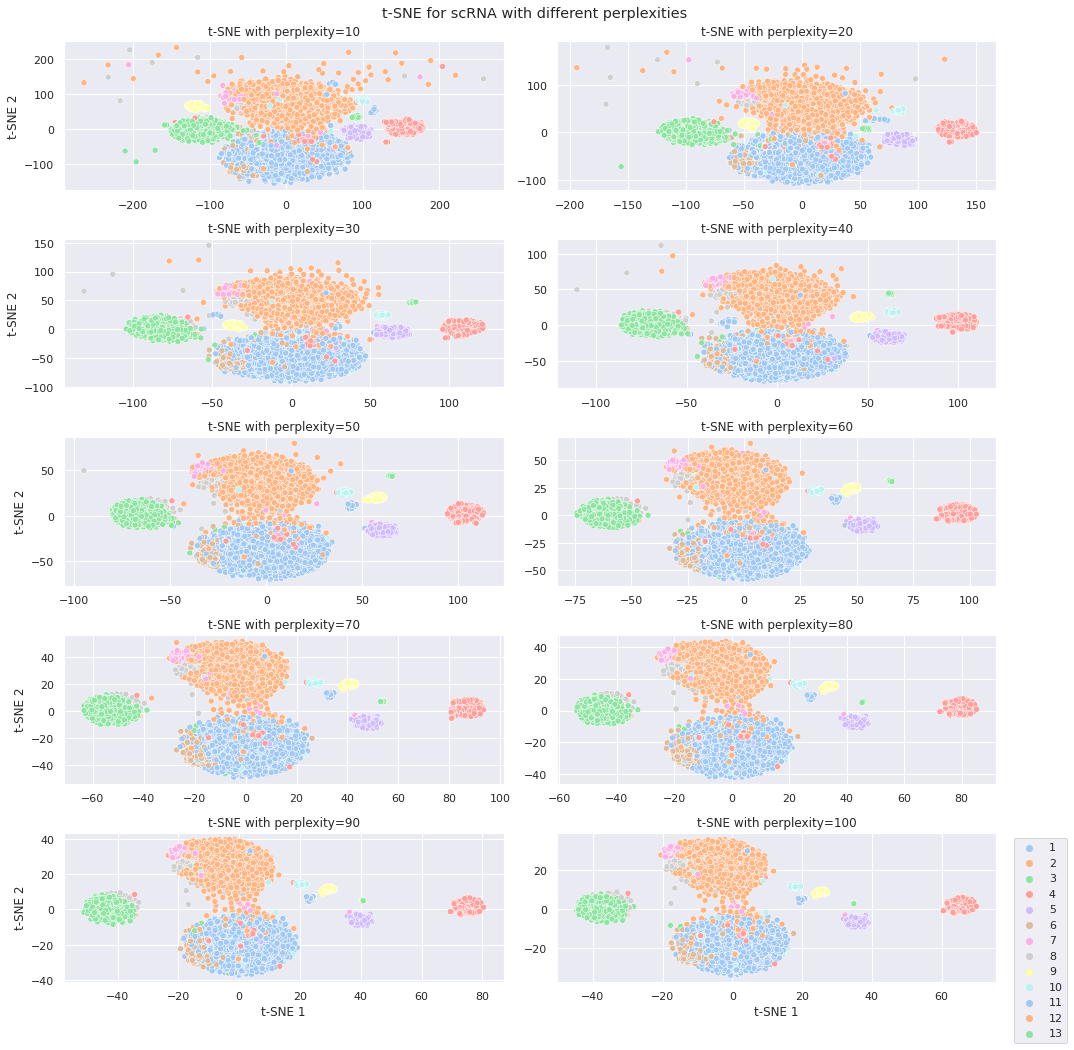

In [134]:
init = PCA(n_components=2).fit_transform(X_scaled)
tsne(X_scaled, Y_scRNAseq, n_components=2, perplexities=perplexities, random_state=42, n_iter=5000, metric="cosine", init=init)

Taking first 47 of principal components and giving first two components from PCA as embedding `init = PCA(n_components=2).fit_transform(X_scaled)
`:

13


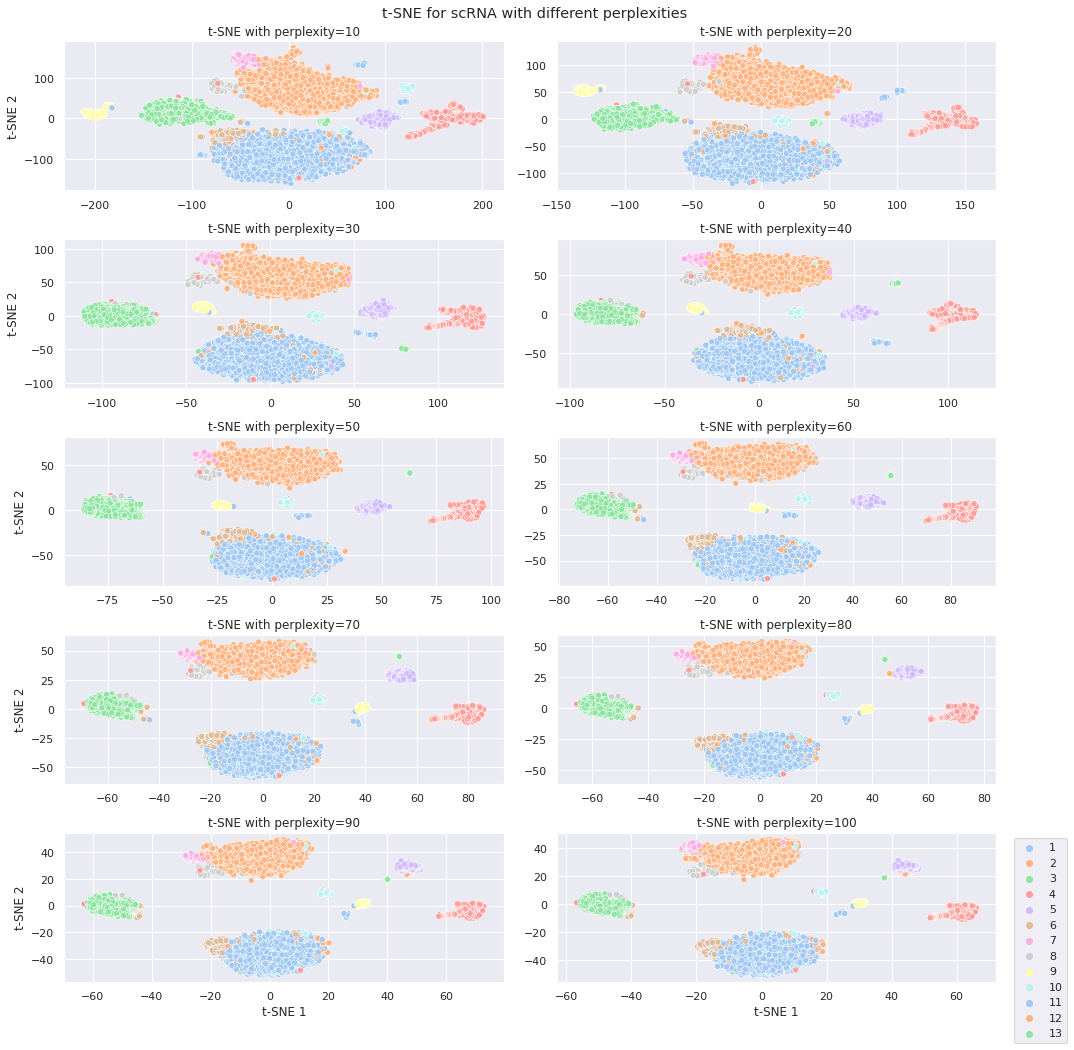

In [135]:
X_reduced = PCA(n_components=47, random_state=42).fit_transform(X_scaled)
tsne(X_reduced, Y_scRNAseq, n_components=2, perplexities=perplexities, random_state=42, n_iter=5000, metric="cosine", init=init)

**Conclusion**:

* IT TOOK TOO LONG.

* Without initializing with first two components and taking metrics as cosinus, no clusters could be identified. However, after initiliazing with PCA components, and even more so, after taking PCA_reduced matrix - the clusterization was much more prominent. If we are generous, we have 8 clusters.

## UMAP

In [89]:
def umap(X_scaled, Y_scRNAseq, n_neighbors_ls, min_dist_ls, random_state, metric):
    n_clusters = len(np.unique(Y_scRNAseq))
    ls_X_embedded = []
    n_rows = len(n_neighbors_ls)
    n_cols = len(min_dist_ls)
    fig, ax = plt.subplots(n_rows, n_cols, squeeze = False, figsize = (30,30))
    fig.suptitle("UMAP for scRNA with different neighbors and minimal distances", fontsize = 30)
    plt.setp(ax[-1, :], xlabel='UMAP 1')
    plt.setp(ax[:, 0], ylabel='UMAP 2')
    for i, n_neighbor in enumerate(n_neighbors_ls):
        for j, min_dist in enumerate(min_dist_ls):
            trans = UMAP(n_neighbors=n_neighbor, min_dist = min_dist, random_state=random_state, metric=metric, n_jobs=-1)
            trans_embedded = trans.fit_transform(X_scaled)
            cur_ax = ax[i, j]
            cur_ax.set_title(f"n_neighbor={n_neighbor}, min_dist={min_dist}")
            if i == n_rows - 1 and j == n_cols - 1:
                sns.scatterplot(trans_embedded[:,0], trans_embedded[:,1], hue=Y_scRNAseq, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)
                cur_ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
            else:
                sns.scatterplot(trans_embedded[:,0], trans_embedded[:,1], hue=Y_scRNAseq, legend=0, palette=sns.color_palette("pastel", n_clusters), ax=cur_ax)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()

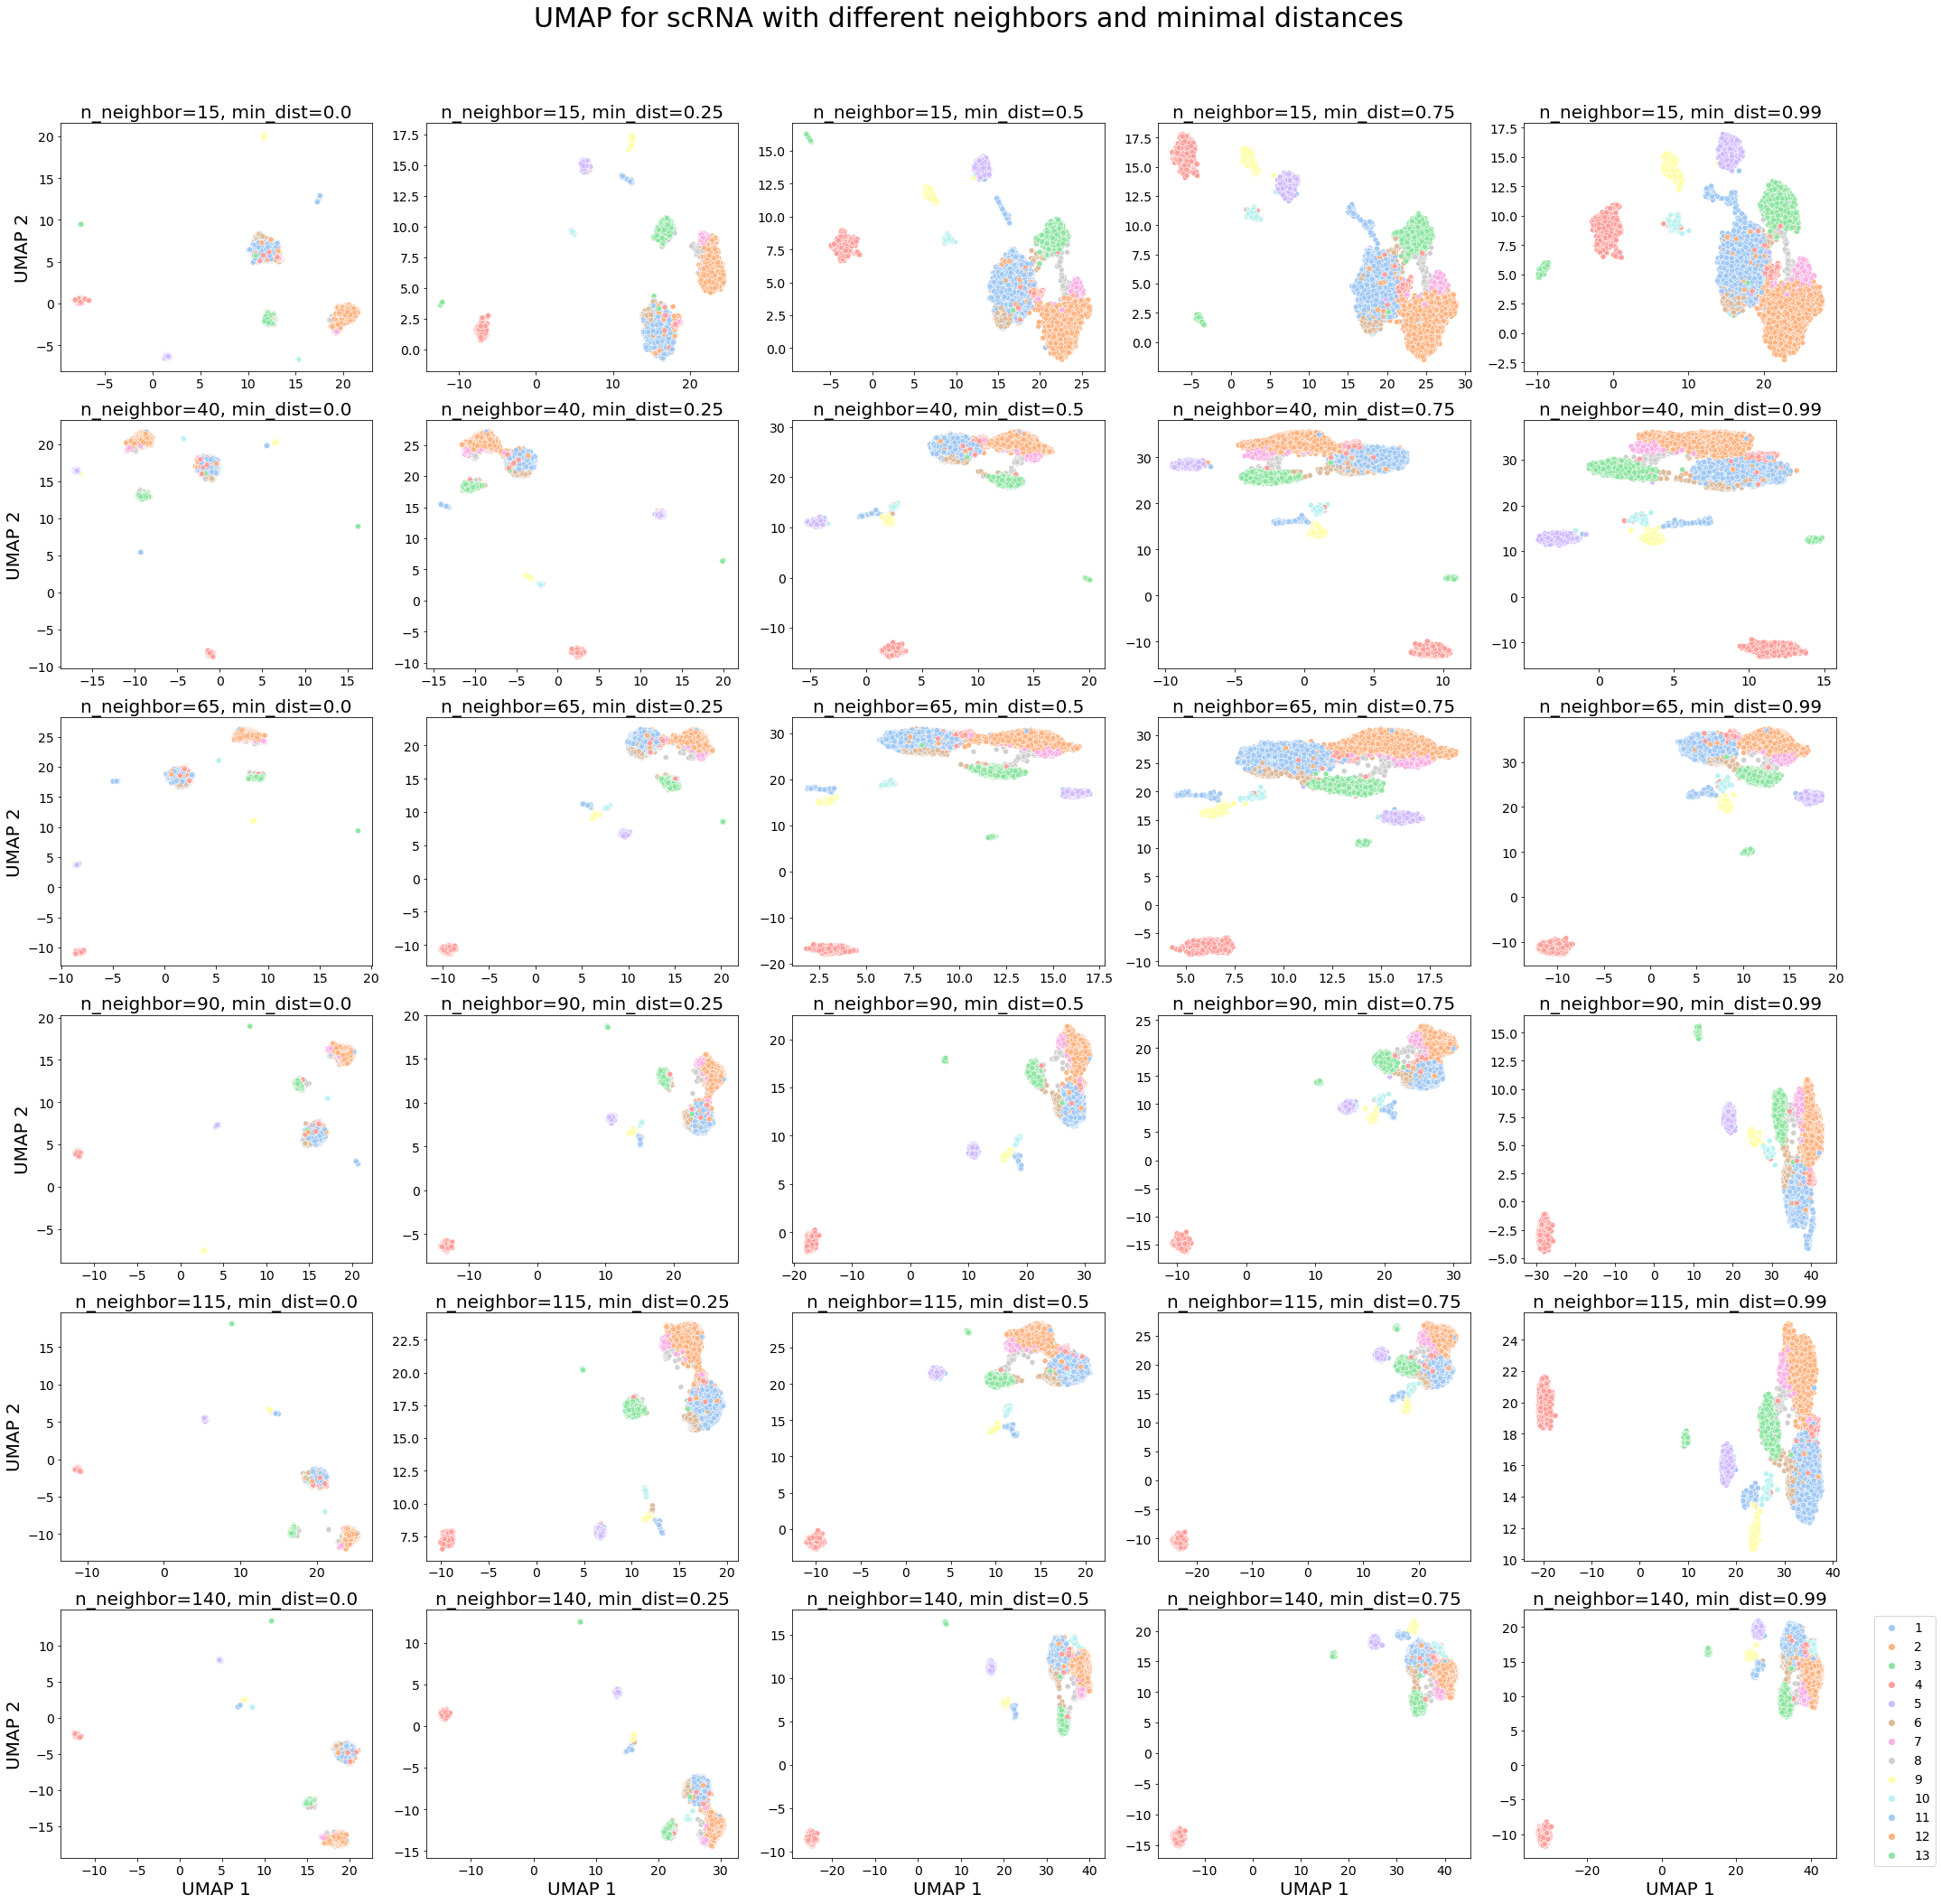

In [90]:
n_neighbors_ls = list(range(15, 155, 25))
min_dist_ls = list((0.0, 0.25, 0.5, 0.75, 0.99))
# n_neighbors_ls = [5, 105]
# min_dist_ls = [0.25, 0.5]
umap(X_scaled, Y_scRNAseq, n_neighbors_ls=n_neighbors_ls, min_dist_ls=min_dist_ls, random_state=42, metric="cosine")

**Conclusions**:

* UMAP much faster
* Clusters are also ok, but tSNE has better clusters.

Different cell types have different profile - based on the expression of different genes, they have different phenotypes and can be classified as different cell types. Based on this analysis, it can be concluded that 13 clusters (13 different cell types based on the provided transcriptomics data) are too many - some cells seem to have similar transcriptome. Based on this, 8-10 different cell types could be classified. 